<a href="https://colab.research.google.com/github/StephaniePC1/ThisIsWhatIDoNow/blob/master/GPVII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Guided Project: Winning Jeopardy

In [310]:
import pandas as pd
import csv

path = 'https://github.com/StephaniePC1/ThisIsWhatIDoNow/raw/master/JEOPARDY_CSV.zip'
jeopardy = pd.read_csv(path, compression='zip')

In [311]:
jeopardy.head(30)

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams
5,4680,2004-12-31,Jeopardy!,3-LETTER WORDS,$200,"In the title of an Aesop fable, this insect sh...",the ant
6,4680,2004-12-31,Jeopardy!,HISTORY,$400,Built in 312 B.C. to link Rome & the South of ...,the Appian Way
7,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$400,"No. 8: 30 steals for the Birmingham Barons; 2,...",Michael Jordan
8,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$400,"In the winter of 1971-72, a record 1,122 inche...",Washington
9,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$400,This housewares store was named for the packag...,Crate & Barrel


In [312]:
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [313]:
jeopardy.columns = ['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question', 'Answer']

In [314]:
import re

def normalize_text(text):
    text = text.lower()
    text = re.sub("[^A-Za-z0-9\s]", "", text)
    text = re.sub("\s+", " ", text)
    return text

def normalize_values(text):
    text = re.sub("[^A-Za-z0-9\s]", "", text)
    try:
        text = int(text)
    except Exception:
        text = 0
    return text

In [315]:
jeopardy['Answer'] = jeopardy['Answer'].astype(str)

In [316]:
jeopardy["clean_question"] = jeopardy["Question"].apply(normalize_text)
jeopardy["clean_value"] = jeopardy["Value"].apply(normalize_values)
jeopardy["clean_answer"] = jeopardy["Answer"].apply(normalize_text)

In [317]:
jeopardy.head(5)

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_value,clean_answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,200,copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisle i...,200,jim thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,200,arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,in 1963 live on the art linkletter show this c...,200,mcdonalds
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,signer of the dec of indep framer of the const...,200,john adams


In [318]:
jeopardy["Air Date"] = pd.to_datetime(jeopardy["Air Date"])

In [319]:
jeopardy.dtypes

Show Number                int64
Air Date          datetime64[ns]
Round                     object
Category                  object
Value                     object
Question                  object
Answer                    object
clean_question            object
clean_value                int64
clean_answer              object
dtype: object

In [320]:
def count_matches(row):
    split_answer = row["Answer"].split()
    split_question = row["clean_question"].split()
    if "the" in split_answer:
        split_answer.remove("the")
    if len(split_answer) == 0:
        return 0
    match_count = 0
    for item in split_answer:
        if item in split_question:
            match_count += 1
    return match_count / len(split_answer)

In [321]:
jeopardy["answer_in_question"] = jeopardy.apply(count_matches, axis=1)

In [322]:
j_mean= jeopardy["answer_in_question"].mean()
print(round(j_mean ,4))

0.029


In [323]:
question_overlap = []
terms_used = set()

jeopardy = jeopardy.sort_values("Air Date")

for i, row in jeopardy.iterrows():
        split_question = row["clean_question"].split(" ")
        split_question = [q for q in split_question if len(q) > 5]
        match_count = 0
        for word in split_question:
            if word in terms_used:
                match_count += 1
        for word in split_question:
            terms_used.add(word)
        if len(split_question) > 0:
            match_count /= len(split_question)
        question_overlap.append(match_count)
jeopardy["question_overlap"] = question_overlap

j_mean_2=jeopardy["question_overlap"].mean()
print(round(j_mean_2 ,4))

0.8722


In [324]:
def determine_value(row):
    value = 0
    if row["clean_value"] > 800:
        value = 1
    return value

jeopardy["high_value"] = jeopardy.apply(determine_value, axis=1)

In [325]:
def count_usage(term):
    low_count = 0
    high_count = 0
    for i, row in jeopardy.iterrows():
        if term in row["clean_question"].split(" "):
            if row["high_value"] == 1:
                high_count += 1
            else:
                low_count += 1
    return high_count, low_count

In [326]:
from random import choice

terms_used_list = list(terms_used)
comparison_terms = [choice(terms_used_list) for _ in range(10)]

observed_expected = []

for term in comparison_terms:
    observed_expected.append(count_usage(term))

observed_expected

[(1, 3),
 (3, 6),
 (0, 1),
 (9, 17),
 (0, 1),
 (1, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (4, 10)]

In [327]:
from scipy.stats import chisquare
import numpy as np

high_value_count = jeopardy[jeopardy["high_value"] == 1].shape[0]
low_value_count = jeopardy[jeopardy["high_value"] == 0].shape[0]

chi_squared = []
for obs in observed_expected:
    total = sum(obs)
    total_prop = total / jeopardy.shape[0]
    high_value_exp = total_prop * high_value_count
    low_value_exp = total_prop * low_value_count
    
    observed = np.array([obs[0], obs[1]])
    expected = np.array([high_value_exp, low_value_exp])
    chi_squared.append(chisquare(observed, expected))

chi_squared

[Power_divergenceResult(statistic=0.021646150708492677, pvalue=0.8830323245068887),
 Power_divergenceResult(statistic=0.1117022816672141, pvalue=0.7382143734273121),
 Power_divergenceResult(statistic=0.3949764642333513, pvalue=0.5296950912486695),
 Power_divergenceResult(statistic=0.5086041756491173, pvalue=0.47574372283130983),
 Power_divergenceResult(statistic=0.3949764642333513, pvalue=0.5296950912486695),
 Power_divergenceResult(statistic=2.5317964247338085, pvalue=0.11157312838169751),
 Power_divergenceResult(statistic=0.3949764642333513, pvalue=0.5296950912486695),
 Power_divergenceResult(statistic=0.3949764642333513, pvalue=0.5296950912486695),
 Power_divergenceResult(statistic=0.3949764642333513, pvalue=0.5296950912486695),
 Power_divergenceResult(statistic=0.00045637279114811905, pvalue=0.9829561814854998)]

#Research: Efficient Studying

##Introduction

  Jeopardy! as a game show requires months, if not years, of preparation to prepare for. Because of this huge preparation requirement, it makes since to try and optimize our studying by focusing on topics or subjects that are more likely appear. We will be looking at the data from game 4680 to 4999 to determine if there are answers that frequently appear. Jeopardy! is also known for their fun and unique categories, but we will also analyze the categories to see if there is a trend of repeated general categories.

In [328]:
counts=jeopardy["clean_answer"].value_counts()
counts

china                               216
australia                           215
chicago                             196
japan                               196
france                              193
                                   ... 
vatican city or san marino            1
a mighty wind                         1
circus maximus                        1
telephone book                        1
killing two birds with one stone      1
Name: clean_answer, Length: 75014, dtype: int64

In [329]:
repeat_answers = jeopardy.loc[jeopardy['clean_answer'].isin(counts.index[counts > 2])]

In [330]:
repeat_answers2= jeopardy.loc[jeopardy['clean_answer'].isin(counts.index[counts > 5])]

In [331]:
repeat_answers3= jeopardy.loc[jeopardy['clean_answer'].isin(counts.index[counts > 10])]

In [332]:
repeat_answers4 = jeopardy.loc[jeopardy['clean_answer'].isin(counts.index[counts > 161])]

In [333]:
round(len(repeat_answers)/len(jeopardy) ,4)*100

68.67

In [334]:
round(len(repeat_answers2)/len(jeopardy) ,5)*100

50.856

In [335]:
round(len(repeat_answers3)/len(jeopardy) ,4)*100

35.82

In [336]:
repeat_answers4["clean_answer"].value_counts()

china         216
australia     215
chicago       196
japan         196
france        193
india         185
california    180
canada        176
spain         171
mexico        164
Name: clean_answer, dtype: int64

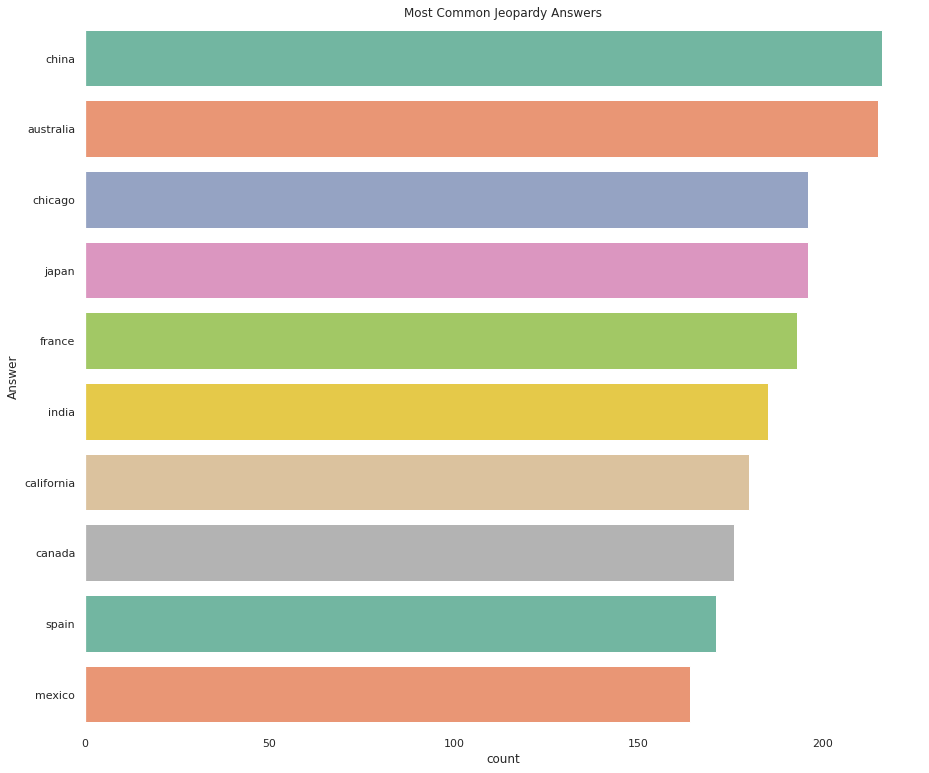

In [337]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15,13)})
top_answers=sns.countplot(y="clean_answer", data= repeat_answers4, palette="Set2", order = repeat_answers4["clean_answer"].value_counts().index)
top_answers.set_title('Most Common Jeopardy Answers')
top_answers.set_ylabel('Answer')
top_answers.set_facecolor('white')

In [338]:
counts=jeopardy["Category"].value_counts()
counts

BEFORE & AFTER                  547
SCIENCE                         519
LITERATURE                      496
AMERICAN HISTORY                418
POTPOURRI                       401
                               ... 
20th CENTURY ENTERTAINMENT        1
WORDS IN 20th CENTURY NOVELS      1
HISTORIC AREAS                    1
RETAIL                            1
MEDICAL CONDITIONS                1
Name: Category, Length: 27995, dtype: int64

In [339]:
repeat_categories = jeopardy.loc[jeopardy['Category'].isin(counts.index[counts > 5])]

In [340]:
round(len(repeat_categories)/len(jeopardy) ,6)*100

49.7027

In [341]:
repeat_categories2 = jeopardy.loc[jeopardy['Category'].isin(counts_cat.index[counts > 10])]

In [342]:
round(len(repeat_categories2)/len(jeopardy) ,6)*100

38.2598

In [343]:
repeat_categories3 = jeopardy.loc[jeopardy['Category'].isin(counts_cat.index[counts > 340])]

In [344]:
repeat_categories3["Category"].value_counts()

BEFORE & AFTER             547
SCIENCE                    519
LITERATURE                 496
AMERICAN HISTORY           418
POTPOURRI                  401
WORLD HISTORY              377
WORD ORIGINS               371
COLLEGES & UNIVERSITIES    351
HISTORY                    349
SPORTS                     342
Name: Category, dtype: int64

Text(0, 0.5, 'Category')

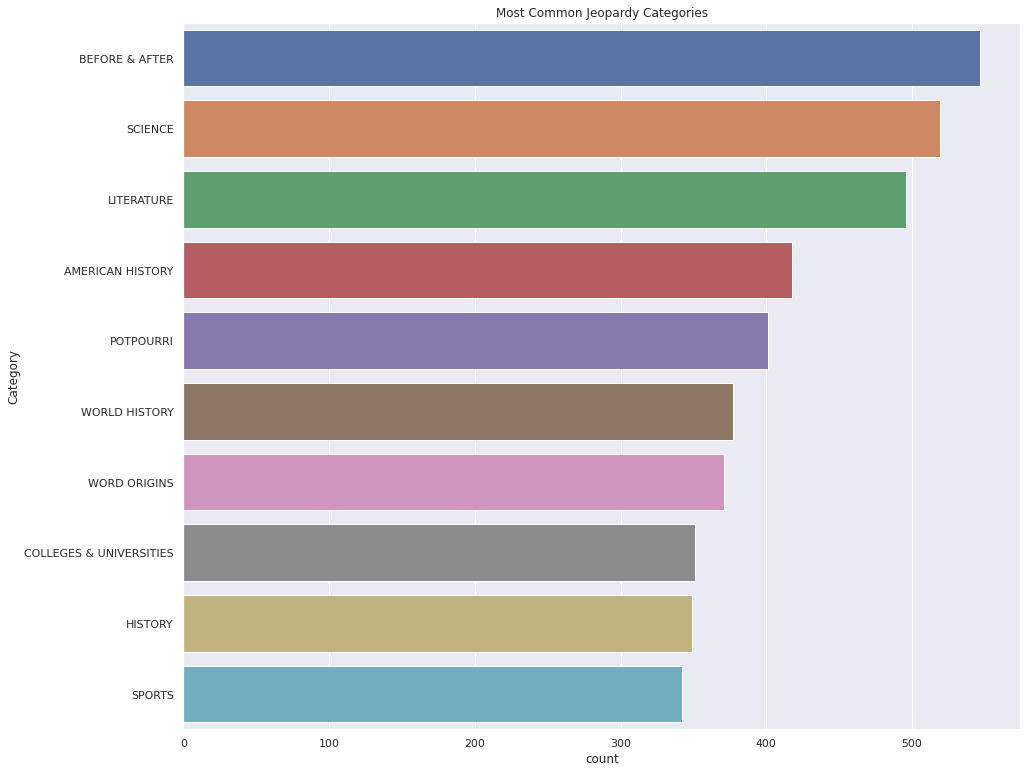

In [345]:
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15,13)})
top_categories=sns.countplot(y="Category", data= repeat_categories3,  order = repeat_categories3["Category"].value_counts().index)
top_categories.set_title('Most Common Jeopardy Categories')
top_categories.set_ylabel('Category')

In [346]:
68/319

0.21316614420062696

##Conclusion

  The results of our analysis finds that 69% of the answers on Jeopardy! are repeated at least once and 51% are repeated 5 times. This means that if it would pay to look at the answers that are commonly given so that we can learn trivia aboout those topics. The top 10 jeopardy answers are all locations with China, Australia, Chicago, Japan, and France taking the top five positions. This indicates that most answers will be country or city based and that it would benefit a propective Jeopardy! contest should learn trivia about these places.

  In addition to looking at the answers to assess which topics are best to study, we also analyed the categories to see which subjects would be best to study. Each Category in Jeopardy! is used up to five times per episode as there are five biding options. In general, Jeopardy! categories are used more than once 50% of the time, and more than twice times 38% of the time. The top 10 categories were all appeared more than 340 times, so at a they appeared at least 68 times in the 319 games we observed so the top ten categories appear in over a fifth of the games. This means that it would behoove a prospective Jeopardy! contestant to study the the commonly used subjects and especially stress the topics/answers we found to most often appear.